In [59]:
import pandas as pd 
from auviewer import lfs
import matplotlib.pyplot as plt

import numpy as np


from snorkel.labeling.model import LabelModel
from snorkel.labeling import PandasLFApplier

In [60]:
df_train = pd.read_csv("/Users/qingyang/desktop/AutonLab/resuscitation-project/for_sophia/statistics.csv")

In [61]:
# Reference: Snorkel Labeling Model https://www.snorkel.org/use-cases/01-spam-tutorial

# Define the label mappings for convenience
ABSTAIN = -1
INSUFFICIENT = 0
SUFFICIENT = 1

In [62]:
# ART_mean_lower = getattr(lfs, "ART_mean_lower", None)
# SvO2_mean_lower = getattr(lfs, "SvO2_mean_lower", None)

In [63]:
from snorkel.labeling import labeling_function

In [64]:
@labeling_function()
def ART_mean_lower(pig):
    if pig['ART_mean [5 min]'] >= 60:
        return SUFFICIENT
    else:
        return ABSTAIN

@labeling_function()
def ART_mean_higher(pig):
    if pig['ART_mean [5 min]'] <= 70:
        return ABSTAIN
    else:
        return SUFFICIENT

@labeling_function()
def SvO2_mean_higher(pig):
    if pig['SvO2_mean [2 min]'] <= 65:
        return SUFFICIENT
    else:
        return ABSTAIN

@labeling_function()
def SvO2_mean_lower(pig):
    if pig['SvO2_mean [2 min]'] >= 60:
        return SUFFICIENT
    else:
        return ABSTAIN

In [65]:
lfs_list = [ART_mean_lower, ART_mean_higher, SvO2_mean_higher, SvO2_mean_lower]

In [66]:
df_train.head()

,Unnamed: 0,pigID,timestamp,ART_mean [2 min],ART_mean [5 min],SvO2_mean [2 min],SvO2_mean [5 min]
0,2234776,1,1.584568e+09,56.643520,55.227082,64.250973,65.595810
1,2249776,1,1.584568e+09,57.115467,55.933776,64.449915,65.027738
2,2264776,1,1.584568e+09,62.376178,58.395111,62.088908,63.943731
3,2279776,1,1.584568e+09,70.819568,62.541599,61.264488,62.914399
4,2294776,1,1.584568e+09,75.003000,66.241495,62.809698,63.031194


In [67]:
# df_train[df_train["ART_mean [5 min]"].apply(lambda x: not isinstance(x, float)) == False]

In [68]:
# Apply the LFs to the unlabeled training data
applier = PandasLFApplier(lfs_list)
L_train = applier.apply(df_train)
# L_train: label matrix, L[i, j] is the label that the jth labeling function output for the ith data point



100%|██████████| 265/265 [00:00<00:00, 12498.91it/s]


In [69]:
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train, n_epochs=500, log_freq=50, seed=123)
df_train["snorkel_label"] = label_model.predict(L=L_train, tie_break_policy="abstain")

100%|██████████| 500/500 [00:00<00:00, 4359.77epoch/s]


In [70]:
df_train.head(100)

,Unnamed: 0,pigID,timestamp,ART_mean [2 min],ART_mean [5 min],SvO2_mean [2 min],SvO2_mean [5 min],snorkel_label
0,2234776,1,1.584568e+09,56.643520,55.227082,64.250973,65.595810,0
1,2249776,1,1.584568e+09,57.115467,55.933776,64.449915,65.027738,0
2,2264776,1,1.584568e+09,62.376178,58.395111,62.088908,63.943731,0
3,2279776,1,1.584568e+09,70.819568,62.541599,61.264488,62.914399,0
4,2294776,1,1.584568e+09,75.003000,66.241495,62.809698,63.031194,0
...,...,...,...,...,...,...,...,...
95,3093690,32,1.652989e+09,70.280733,70.934194,66.922316,67.415215,1
96,3108690,32,1.652989e+09,67.933953,69.930473,67.863409,67.452199,1
97,3123690,32,1.652989e+09,68.261854,69.645633,80.533267,72.435314,1
98,3138690,32,1.652989e+09,70.146469,69.557791,91.596304,77.188301,1


In [71]:
if "normalized_t [min]" not in df_train:
    df_train.insert(loc = 1, column = "normalized_t [min]", value = df_train["timestamp"] - df_train["timestamp"][0])

In [72]:
df_train["normalized_t [min]"] = df_train["normalized_t [min]"] / 60

In [73]:
### The following is from Ryan's 02_featurization.ipynb

# Read annotations from the doctors for sufficiency
df_annot = pd.read_csv("/Users/qingyang/desktop/AutonLab/resuscitation-project/for_sophia/sufficiency_annotations.csv")

# Extract and add pig id as a column
pig_ids = [file[:2] for file in df_annot['filename']]
df_annot['pigID'] = pig_ids

df_annot = df_annot.loc[df_annot['user_lastname'] == 'Gomez']





In [74]:
from datetime import datetime

# Convert the datetime columns to total seconds since epoch
df_annot['left'] = df_annot['left'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f").timestamp())
df_annot['right'] = df_annot['right'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f").timestamp())

# Save the processed suffiency annotations to a csv
df_annot.to_csv('gomez_processed_sufficiency_annotations.csv', index=False)
df_annot

,file_id,filename,user_id,user_email,user_firstname,user_lastname,pattern_set_id,pattern_id,series,left,right,top,bottom,label,created,pattern_identifier,pigID
53,25801,03_ControlledReFit1.0.h5,43,gomezh@upmc.edu,Hernando,Gomez,NaN,NaN,/data:ART_mean,1.598387e+09,1.598388e+09,NaN,NaN,"{""confidence"":""1"",""notes"":""There is much oscil...",2023-05-31 12:39:48,19_25801_/data:ART_mean_1598387173.325_1598388...,03
54,25802,05_ControlledReFit1.0.h5,43,gomezh@upmc.edu,Hernando,Gomez,NaN,NaN,/data:ART_mean,1.599769e+09,1.599770e+09,NaN,NaN,"{""confidence"":""2"",""notes"":""Taking baseline MAP...",2023-05-31 12:46:22,19_25802_/data:ART_mean_1599768868.858_1599769...,05
55,25785,08_ControlledReFit1.0.h5,43,gomezh@upmc.edu,Hernando,Gomez,NaN,NaN,/data:ART_mean,1.602620e+09,1.602623e+09,NaN,NaN,"{""confidence"":""2"",""notes"":""""}",2023-05-31 12:58:15,19_25785_/data:ART_mean_1602620294.871_1602623...,08
56,25797,09_ControlledReFit1.0.h5,43,gomezh@upmc.edu,Hernando,Gomez,NaN,NaN,/data:SvO2_mean,1.603227e+09,1.603229e+09,NaN,NaN,"{""confidence"":""3"",""notes"":""""}",2023-05-31 13:00:58,19_25797_/data:SvO2_mean_1603227300.739_160322...,09
57,25797,09_ControlledReFit1.0.h5,43,gomezh@upmc.edu,Hernando,Gomez,NaN,NaN,/data:SvO2_mean,1.603230e+09,1.603231e+09,NaN,NaN,"{""confidence"":""3"",""notes"":""""}",2023-05-31 13:01:30,19_25797_/data:SvO2_mean_1603229677.352_160323...,09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,25820,43_ControlHG.h5,43,gomezh@upmc.edu,Hernando,Gomez,NaN,NaN,/data:ART_mean,1.675803e+09,1.675806e+09,NaN,NaN,"{""confidence"":""3"",""notes"":""""}",2023-05-31 18:37:51,19_25820_/data:ART_mean_1675803225.553_1675806...,43
185,25814,46_ControlHG.h5,43,gomezh@upmc.edu,Hernando,Gomez,NaN,NaN,/data:ART_mean,1.679430e+09,1.679430e+09,NaN,NaN,"{""confidence"":""3"",""notes"":""""}",2023-05-31 18:38:24,19_25814_/data:ART_mean_1679429658.553_1679429...,46
186,25814,46_ControlHG.h5,43,gomezh@upmc.edu,Hernando,Gomez,NaN,NaN,/data:ART_mean,1.679430e+09,1.679431e+09,NaN,NaN,"{""confidence"":""3"",""notes"":""""}",2023-05-31 18:38:33,19_25814_/data:ART_mean_1679430135.861_1679431...,46
187,25814,46_ControlHG.h5,43,gomezh@upmc.edu,Hernando,Gomez,NaN,NaN,/data:ART_mean,1.679432e+09,1.679437e+09,NaN,NaN,"{""confidence"":""3"",""notes"":""""}",2023-05-31 18:38:40,19_25814_/data:ART_mean_1679431854.168_1679437...,46


In [75]:
# Create a dictionary mapping a pig id to a list of tuples specifying the sufficient interval
# e.g., pigid 03 -> [(1, 2), (4,5)] where 1 is a lower value and 2 the coressponding upper value
pigid_intervals = {}
for index, row in df_annot.iterrows():
    pigid = float(row['pigID'])
    if pigid not in pigid_intervals:
        pigid_intervals[pigid] = [(row['left'], row['right'])]
    else:
        pigid_intervals[pigid].append((row['left'], row['right']))


pigid_intervals

{3.0: [(1598387173.325, 1598388231.099),
  (1598389790.354, 1598390044.427),
  (1598390119.982, 1598390522.944),
  (1598391299.239, 1598391530.348)],
 5.0: [(1599768868.858, 1599769698.72),
  (1599773590.988, 1599774918.122),
  (1599775442.803, 1599778899.526)],
 8.0: [(1602620294.871, 1602623190.471)],
 9.0: [(1603227300.739, 1603229153.692),
  (1603229677.352, 1603230799.879),
  (1603233469.906, 1603234195.819),
  (1603231089.24, 1603233184.727)],
 10.0: [(1603837920.179, 1603841045.526), (1603835862.024, 1603836776.76)],
 11.0: [(1615930531.754, 1615933498.021), (1615925767.523, 1615926337.033)],
 1.0: [(1584568997.882, 1584569728.115)],
 7.0: [(1600980015.458, 1600981466.106)],
 12.0: [(1616092624.675, 1616098769.364)],
 13.0: [(1616711388.931, 1616712488.762),
  (1616706736.796, 1616707831.04),
  (1616708205.387, 1616709069.264),
  (1616709529.999, 1616710134.713),
  (1616710364.945, 1616711113.639),
  (1616705756.979, 1616706264.594),
  (1616704699.45, 1616705291.666)],
 14.0: [(

In [76]:
pigid_intervals[32]

[(1652993603.412, 1652995189.495),
 (1652989959.709, 1652991545.792),
 (1652992060.197, 1652992831.805),
 (1652996904.179, 1652997632.92),
 (1652997890.122, 1652998318.793),
 (1652998533.129, 1652999047.534)]

In [77]:
# df_train = df_train[df_train["pigID"] == 32]

In [78]:
xmin = [x1 for (x1, x2) in pigid_intervals[32]]
xmax = [x2 for (x1, x2) in pigid_intervals[32]]
xmax

[1652995189.495,
 1652991545.792,
 1652992831.805,
 1652997632.92,
 1652998318.793,
 1652999047.534]

In [79]:
xmin

[1652993603.412,
 1652989959.709,
 1652992060.197,
 1652996904.179,
 1652997890.122,
 1652998533.129]

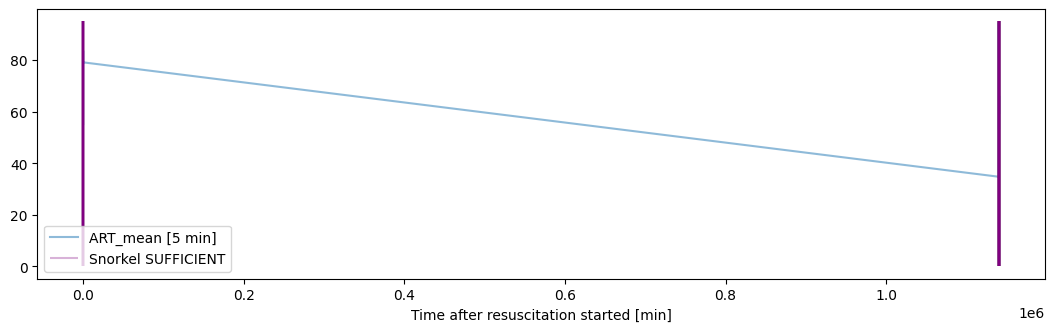

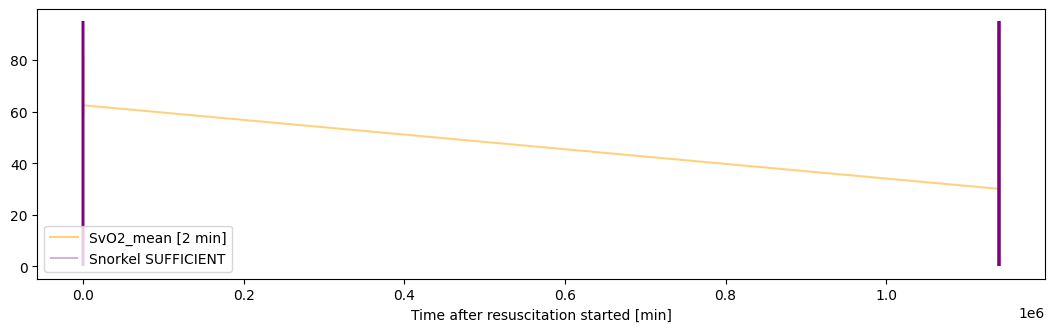

In [80]:
plt.figure(figsize=(13, 3.5))
plt.plot(df_train["normalized_t [min]"], df_train["ART_mean [5 min]"], color="C0", alpha=0.5, label="ART_mean [5 min]") # raw time series, 250Hz
# plt.plot(df_train["normalized_t [min]"], df_train["SvO2_mean [2 min]"], color="orange", alpha=0.5, label="SvO2_mean [2 min]")

    t.scatter(df_train["timestamp"][(df_train.snorkel_label == 1)], df_train["snorkel_label"][(df_train.snorkel_label == 1)], color="red", s=5)
plt.vlines(df_train["normalized_t [min]"][(df_train.snorkel_label == 1)], 0, 95, color="purple", alpha=0.3, label='Snorkel SUFFICIENT')
# plt.hlines(, xmin, xmax, color = "red")
plt.legend()
plt.xlabel("Time after resuscitation started [min]")
# plt.ylabel("SvO2_mean [2 min]  ART_mean [5 min]")
plt.show()

plt.figure(figsize=(13, 3.5))
# plt.plot(df_train["normalized_t [min]"], df_train["ART_mean [5 min]"], color="C0", alpha=0.5, label="ART_mean [5 min]") # raw time series, 250Hz
plt.plot(df_train["normalized_t [min]"], df_train["SvO2_mean [2 min]"], color="orange", alpha=0.5, label="SvO2_mean [2 min]")

# plt.scatter(df_train["timestamp"][(df_train.snorkel_label == 1)], df_train["snorkel_label"][(df_train.snorkel_label == 1)], color="red", s=5)
plt.vlines(df_train["normalized_t [min]"][(df_train.snorkel_label == 1)], 0, 95, color="purple", alpha=0.3, label='Snorkel SUFFICIENT')
plt.legend()
plt.xlabel("Time after resuscitation started [min]")
# plt.ylabel("SvO2_mean [2 min]  ART_mean [5 min]")
plt.show()

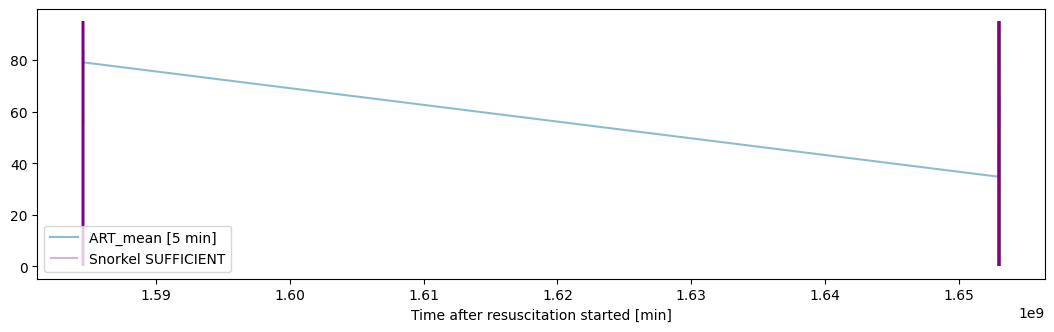

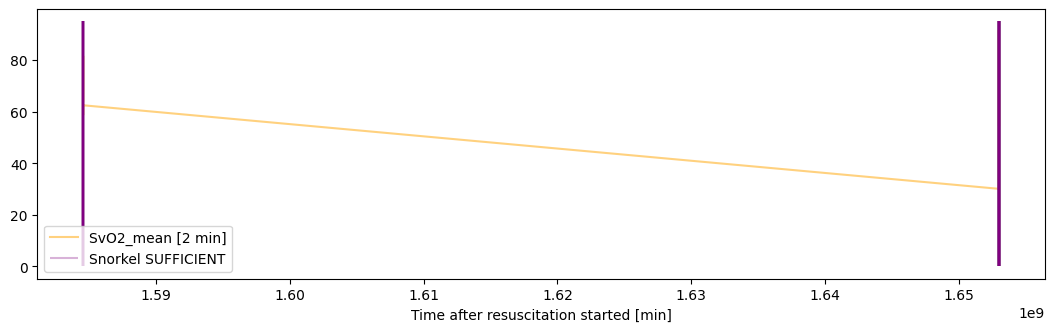

In [81]:
plt.figure(figsize=(13, 3.5))
plt.plot(df_train["timestamp"], df_train["ART_mean [5 min]"], color="C0", alpha=0.5, label="ART_mean [5 min]") # raw time series, 250Hz
# plt.plot(df_train["normalized_t [min]"], df_train["SvO2_mean [2 min]"], color="orange", alpha=0.5, label="SvO2_mean [2 min]")

# plt.scatter(df_train["timestamp"][(df_train.snorkel_label == 1)], df_train["snorkel_label"][(df_train.snorkel_label == 1)], color="red", s=5)
plt.vlines(df_train["timestamp"][(df_train.snorkel_label == 1)], 0, 95, color="purple", alpha=0.3, label='Snorkel SUFFICIENT')
for (xmin, xmax) in pigid_intervals[32]:
    plt.hlines(80, xmin, xmax, color = "red")

    
plt.legend()
plt.xlabel("Time after resuscitation started [min]")
# plt.ylabel("SvO2_mean [2 min]  ART_mean [5 min]")
plt.show()

plt.figure(figsize=(13, 3.5))
# plt.plot(df_train["normalized_t [min]"], df_train["ART_mean [5 min]"], color="C0", alpha=0.5, label="ART_mean [5 min]") # raw time series, 250Hz
plt.plot(df_train["timestamp"], df_train["SvO2_mean [2 min]"], color="orange", alpha=0.5, label="SvO2_mean [2 min]")

# plt.scatter(df_train["timestamp"][(df_train.snorkel_label == 1)], df_train["snorkel_label"][(df_train.snorkel_label == 1)], color="red", s=5)
plt.vlines(df_train["timestamp"][(df_train.snorkel_label == 1)], 0, 95, color="purple", alpha=0.3, label='Snorkel SUFFICIENT')
for (xmin, xmax) in pigid_intervals[32]:
    plt.hlines(80, xmin, xmax, color = "red")
plt.legend()
plt.xlabel("Time after resuscitation started [min]")
# plt.ylabel("SvO2_mean [2 min]  ART_mean [5 min]")
plt.show()

In [83]:
accu_dict = dict.fromkeys(range(1, 46), (0, 0))
intervals = pd.arrays.IntervalArray.from_tuples(pigid_intervals[32])

for i, row in df_train:
    pigID = row["pigID"]
    intervals = pd.arrays.IntervalArray.from_tuples(pigid_intervals[pigID])
    trueSum, falseSum = accu_dict.get(pigID)
    if any(intervals.contains(row["timestamp"])) == row["snorkel_label"]:
        accu_dict[pigID] = (trueSum + 1, falseSum)
    else:
        accu_dict[pigID] = (trueSum, falseSum + 1)



IndentationError: expected an indented block (536222099.py, line 5)